# Ocena jakości wina Vinho Verde

Celem zadania jest ocena jakości wina.

Uwzględniono dwa zbiory danych dotyczące próbek czerwonego wina Vinho Verde z północy Portugalii.

Źródło: 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

- 1600 obserwacji z 11 zmiennymi wejściowymi i jedną zmienną wyjściową.
- Zmienne opisują:
  1. Stałą kwasowość.
  2. Kwasowość lotną.
  3. Kwas cytrynowy.
  4. Cukier resztkowy.
  5. Chlorki.
  6. Wolny dwutlenek siarki.
  7. Całkowity dwutlenek siarki.
  8. Gęstość.
  9. pH.
  10. Siarczany.
  11. Alkohol.
  12. Jakość (ocena od 0 do 10).

[Dane](https://github.com/UEPP40/PUM/blob/c1ab27e52bc82cc151bb217b27bd25dfd057d9e8/winequality-red.csv)


# Import bibliotek, pliku csv oraz wstępny przegląd danych

In [44]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib as hl
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [45]:
# Wczytanie danych z pliku CSV do ramki danych
wineDataFrame = pd.read_csv('winequality-red.csv', sep=";")

# Wyświetlenie pierwszych 5 rekordów wraz z podstawowymi informacjami o danych
print("Pierwsze 5 rekordów zbioru danych:")
print(wineDataFrame.head(5))

print("\nInformacje o zbiorze danych:")
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

print("\nStatystyki opisowe zbioru danych:")
# Wyświetlenie statystyk opisowych zbioru danych
print(wineDataFrame.describe())

Pierwsze 5 rekordów zbioru danych:
   fixed acidity  volatile acidity citric acid residual sugar chlorides  \
0            7.4              0.70           0            1.9     0.076   
1            7.8              0.88           0            2.6     0.098   
2            7.8              0.76        0.04            2.3     0.092   
3           11.2              0.28        0.56            1.9     0.075   
4            7.4              0.70           0            1.9     0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2  

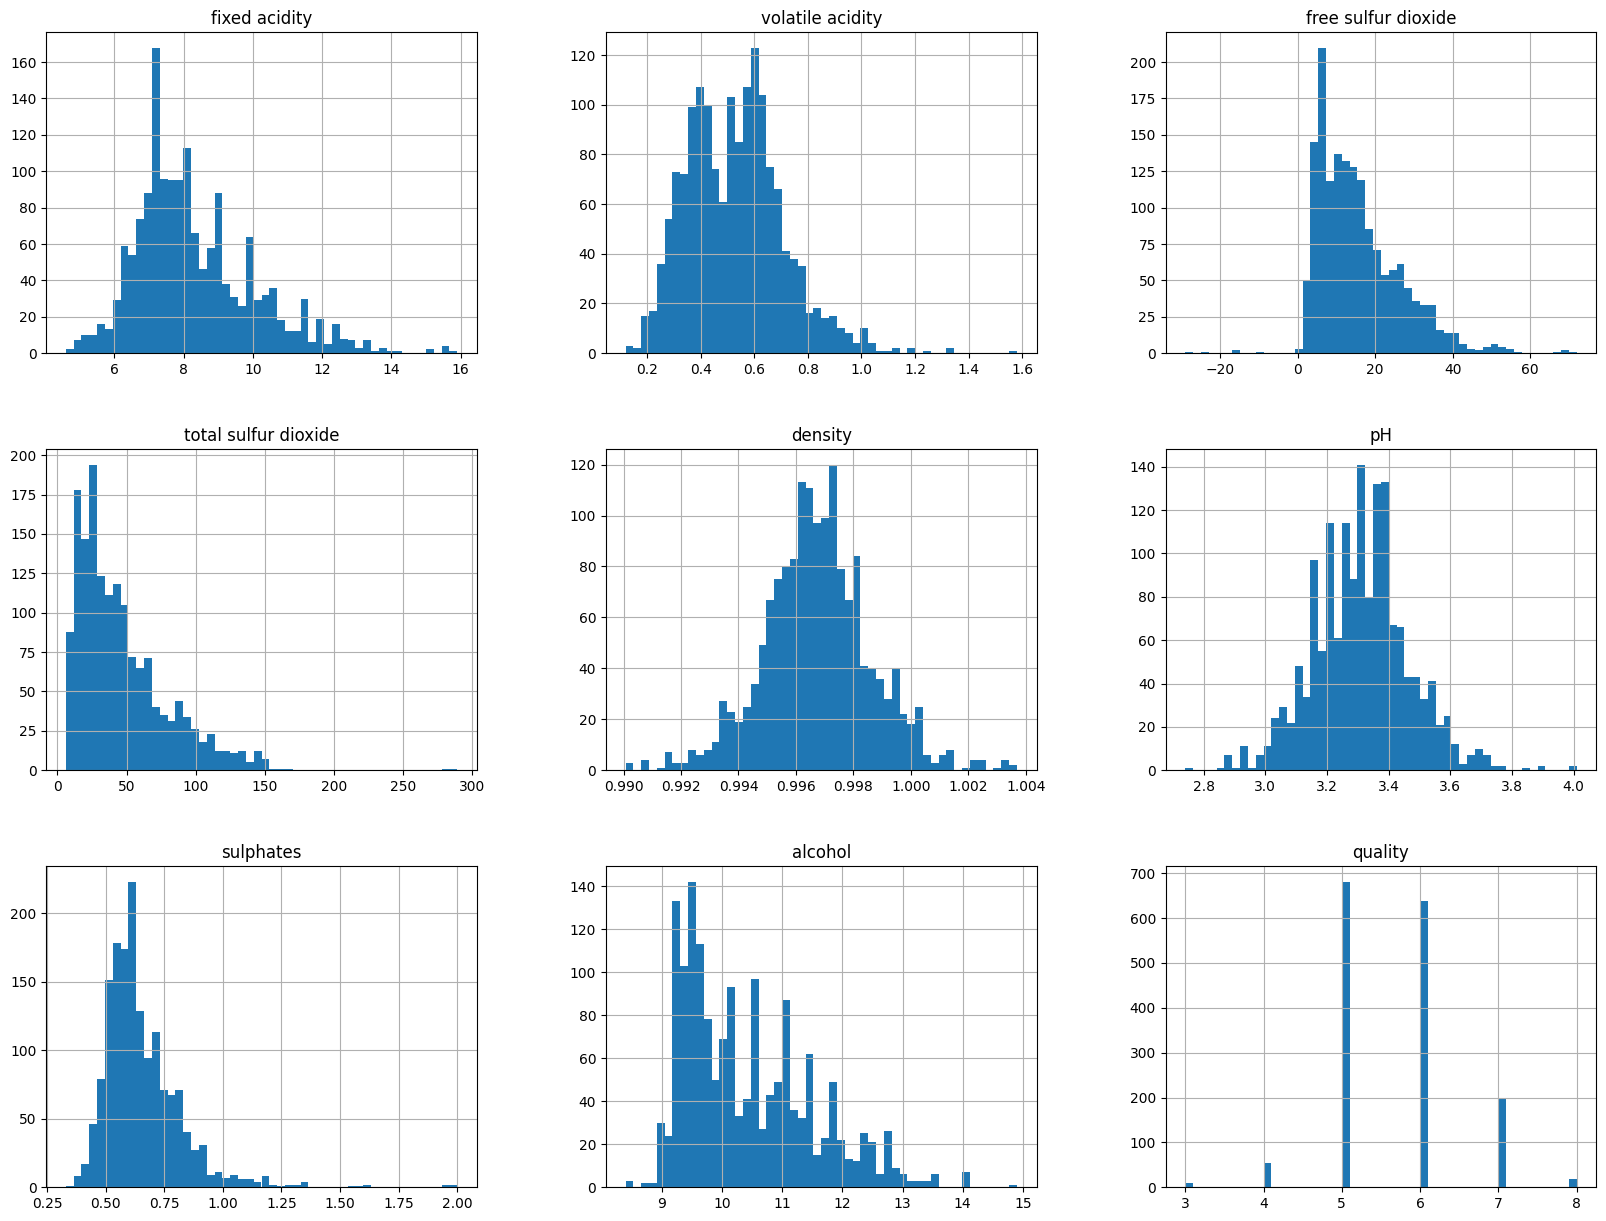

In [46]:
# Narysowanie histogramów dla wszystkich zmiennych oraz kilku innych przydatnych wykresów
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

# Czyszczenie danych

In [47]:
# usuń zbędne znaki (nie będące Ascii)
for column in wineDataFrame.columns:
    wineDataFrame[column] = wineDataFrame[column].astype(str).str.replace(r'[^\x00-\x7F]+', '', regex=True)
# zmien typ zmiennych ilościowych
for column in wineDataFrame.columns:
    wineDataFrame[column] = pd.to_numeric(wineDataFrame[column], errors='coerce')
# Wyświetlenie podstawowych informacji o zbiorze danych
print(wineDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1596 non-null   float64
 3   residual sugar        1598 non-null   float64
 4   chlorides             1596 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1595 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [48]:
# Usuń wiersze z duplikatami
wineDataFrame.drop_duplicates(inplace=True)

# Usuń wiersze z brakującymi danymi
wineDataFrame.fillna(wineDataFrame.median(), inplace=True)

# Display basic information about the data set
print(wineDataFrame.info())
print(wineDataFrame.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1363 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1363 non-null   float64
 1   volatile acidity      1363 non-null   float64
 2   citric acid           1363 non-null   float64
 3   residual sugar        1363 non-null   float64
 4   chlorides             1363 non-null   float64
 5   free sulfur dioxide   1363 non-null   float64
 6   total sulfur dioxide  1363 non-null   float64
 7   density               1363 non-null   float64
 8   pH                    1363 non-null   float64
 9   sulphates             1363 non-null   float64
 10  alcohol               1363 non-null   float64
 11  quality               1363 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.4 KB
None
(1363, 12)


In [49]:
# uzupełnij braki średnią
for column in wineDataFrame.columns:
    if wineDataFrame[column].isnull().sum() > 0:
        wineDataFrame[column] = wineDataFrame[column].fillna(method='pad')

# print empty values
print(wineDataFrame.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [50]:
# usunięcie rekorów z wartościami wyraźnie odstającymi
for column in wineDataFrame.columns:
    if column != 'quality' and pd.api.types.is_numeric_dtype(wineDataFrame[column]):
        Q1 = wineDataFrame[column].quantile(0.05)
        Q3 = wineDataFrame[column].quantile(0.95)
        IQR = Q3 - Q1

        filter = (wineDataFrame[column] >= Q1 - 1.5 * IQR) & (wineDataFrame[column] <= Q3 + 1.5 * IQR)
        wineDataFrame = wineDataFrame.loc[filter]

# Display basic information about the data set
print(wineDataFrame.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1326 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1326 non-null   float64
 1   volatile acidity      1326 non-null   float64
 2   citric acid           1326 non-null   float64
 3   residual sugar        1326 non-null   float64
 4   chlorides             1326 non-null   float64
 5   free sulfur dioxide   1326 non-null   float64
 6   total sulfur dioxide  1326 non-null   float64
 7   density               1326 non-null   float64
 8   pH                    1326 non-null   float64
 9   sulphates             1326 non-null   float64
 10  alcohol               1326 non-null   float64
 11  quality               1326 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 134.7 KB
None


<class 'pandas.core.frame.DataFrame'>
Index: 1326 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1326 non-null   float64
 1   volatile acidity      1326 non-null   float64
 2   citric acid           1326 non-null   float64
 3   residual sugar        1326 non-null   float64
 4   chlorides             1326 non-null   float64
 5   free sulfur dioxide   1326 non-null   float64
 6   total sulfur dioxide  1326 non-null   float64
 7   density               1326 non-null   float64
 8   pH                    1326 non-null   float64
 9   sulphates             1326 non-null   float64
 10  alcohol               1326 non-null   float64
 11  quality               1326 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 134.7 KB
None


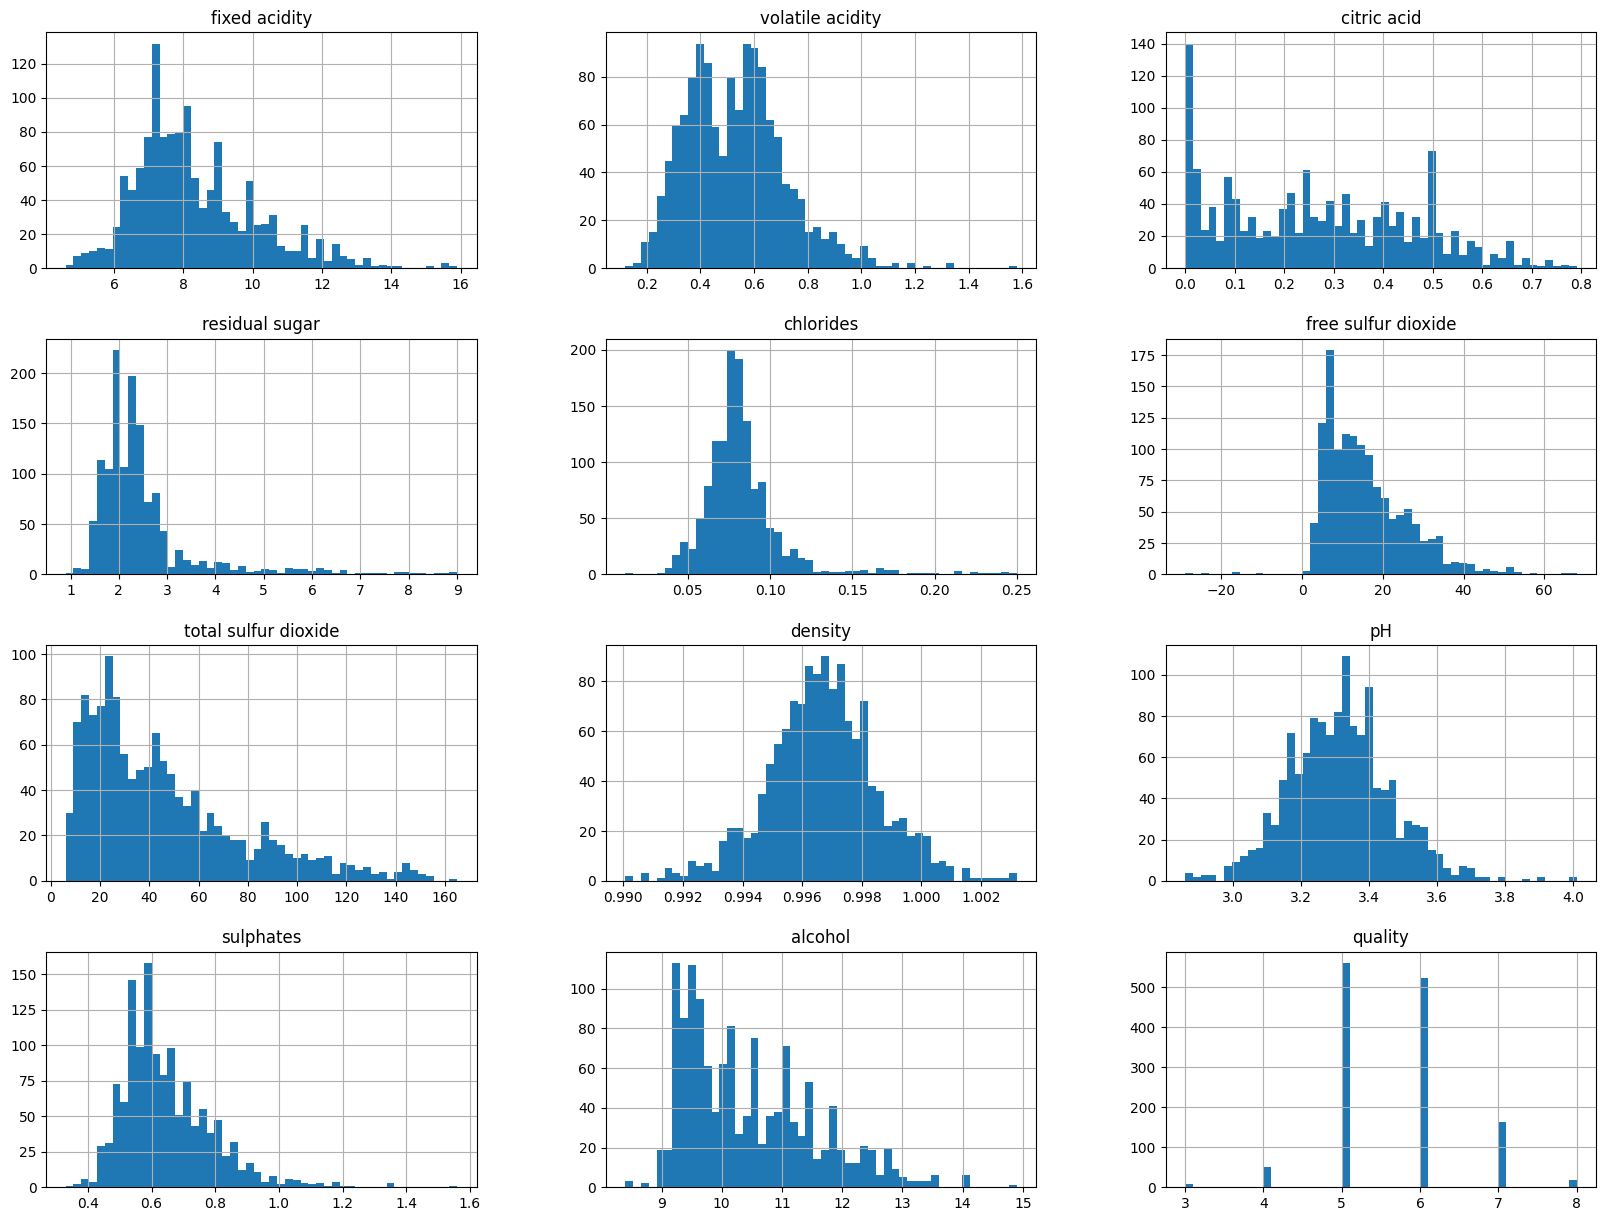

In [51]:
# Display basic information about the data set
print(wineDataFrame.info())
# plot histogram
wineDataFrame.hist(bins=50, figsize=(20,15))
plt.show()

In [52]:
# stwórz obiekt enkodera dla kolumn o typie obiektowym
le = LabelEncoder()
for column in wineDataFrame.columns:
    if pd.api.types.is_object_dtype(wineDataFrame[column]):
        wineDataFrame[column] = le.fit_transform(wineDataFrame[column])
# sprawdź transformacje
wineDataFrame.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


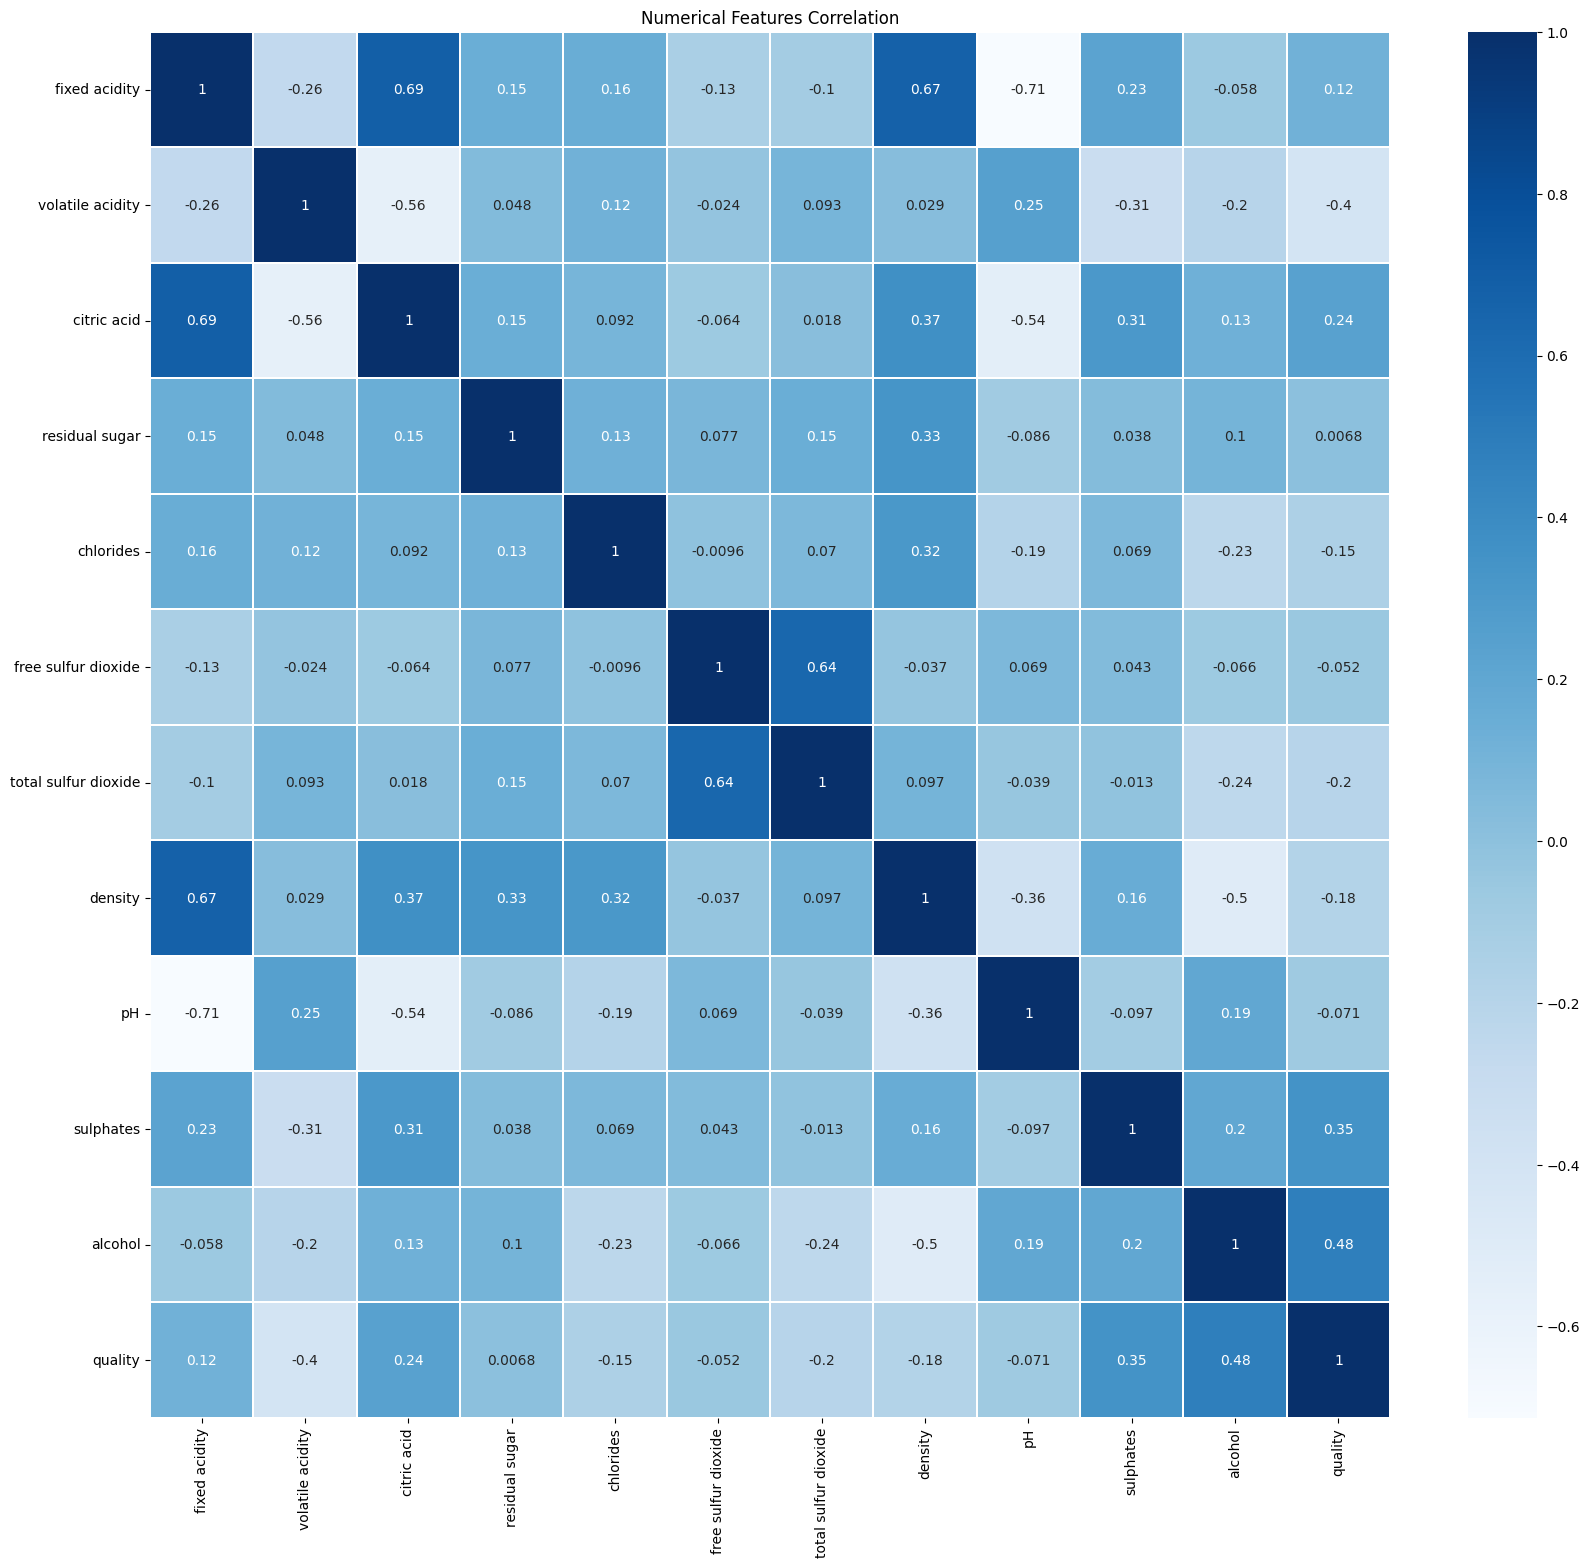

In [53]:
# wskaż korelacje
plt.figure(figsize = (20, 18)) 
# creating the correlation heatmap
sns.heatmap(wineDataFrame.corr(), annot = True, linewidths = 0.1, cmap = 'Blues')
plt.title('Numerical Features Correlation')
plt.show()

In [54]:
corr_matrix = wineDataFrame.corr()
cor_target = abs(corr_matrix["quality"])
relevant_features = cor_target[cor_target>0.1]

# print which features are relevant
print("Relevant features (correlation with 'quality' > 0.1):\n", relevant_features)

# and which are not
print("\nNon-relevant features (correlation with 'quality' <= 0.1):\n", cor_target[cor_target<=0.1])

wineDataFrame = wineDataFrame[relevant_features.index]

Relevant features (correlation with 'quality' > 0.1):
 fixed acidity           0.121987
volatile acidity        0.399058
citric acid             0.240793
chlorides               0.145018
total sulfur dioxide    0.204335
density                 0.183823
sulphates               0.347016
alcohol                 0.482552
quality                 1.000000
Name: quality, dtype: float64

Non-relevant features (correlation with 'quality' <= 0.1):
 residual sugar         0.006788
free sulfur dioxide    0.052140
pH                     0.070965
Name: quality, dtype: float64


In [55]:
wineDataFrame.head(5)

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,5
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,5
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,6
5,7.4,0.66,0.00,0.075,40.0,0.9978,0.56,9.4,5


# Podział danych na zbiory treningowe i testowe

In [56]:
# Podziel dane na zbiór uczący i testowy
X = wineDataFrame.drop(columns=["quality"])
y = wineDataFrame["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Rozmiar zbioru treningowego:", len(X_train))
print("Rozmiar zbioru testowego:", len(X_test))

Rozmiar zbioru treningowego: 928
Rozmiar zbioru testowego: 398


In [57]:
# Display the data splits
print("Training data (features):")
print(X_train.head())
print("\nTest data (features):")
print(X_test.head())
print("\nTraining data (target):")
print(y_train.head())
print("\nTest data (target):")
print(y_test.head())

Training data (features):
      fixed acidity  volatile acidity  citric acid  chlorides  \
638             7.7             0.915         0.12      0.143   
166             6.8             0.640         0.10      0.085   
1494            6.4             0.310         0.09      0.066   
1238            8.1             0.730         0.00      0.081   
269            11.5             0.180         0.51      0.104   

      total sulfur dioxide  density  sulphates  alcohol  
638                   23.0  0.99640       0.65     10.2  
166                  101.0  0.99560       0.52     10.2  
1494                  28.0  0.99459       0.70     10.0  
1238                  24.0  0.99798       0.46      9.6  
269                   23.0  0.99960       0.97     10.1  

Test data (features):
      fixed acidity  volatile acidity  citric acid  chlorides  \
1071            7.5             0.770         0.20      0.098   
557            15.6             0.645         0.49      0.095   
1069            8